In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [122]:
import scipy.stats as st
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

## Numeric Outcomes

In [91]:
X_train = pd.read_csv('datasets/solubility/solTrainXtrans.csv', index_col=0)
y_train = pd.read_csv('datasets/solubility/solTrainY.csv', index_col=0)

In [92]:
X_train.head()

,FP001,FP002,FP003,FP004,FP005,FP006,FP007,FP008,FP009,FP010,...,NumCarbon,NumNitrogen,NumOxygen,NumSulfer,NumChlorine,NumHalogen,NumRings,HydrophilicFactor,SurfaceArea1,SurfaceArea2
661,0,1,0,0,1,0,0,1,0,0,...,4.177811,0.584815,0.000000,-0.000,-0.000,-0.000,1.386294,-1.606542,6.812456,6.812456
662,0,1,0,1,1,1,1,1,0,0,...,5.092358,0.642355,0.693147,0.375,-0.000,-0.000,1.609438,-0.441330,9.753834,12.029604
663,1,1,1,1,1,0,0,1,0,1,...,4.023944,-0.000000,1.098612,-0.000,-0.000,-0.000,0.693147,-0.384859,8.245324,8.245324
665,0,0,1,0,0,0,1,0,0,0,...,3.510455,-0.000000,0.000000,-0.000,-0.000,-0.000,0.693147,-2.373472,0.000000,0.000000
668,0,0,1,1,1,1,0,0,1,0,...,3.317541,0.694335,0.000000,-0.000,0.375,0.375,0.693147,-0.070987,9.913535,9.913535


In [93]:
X_train['Target'] = y_train.values


In [94]:
X_train.shape

(951, 229)

In [95]:
bin_cols = X_train.columns[X_train.nunique() ==2]

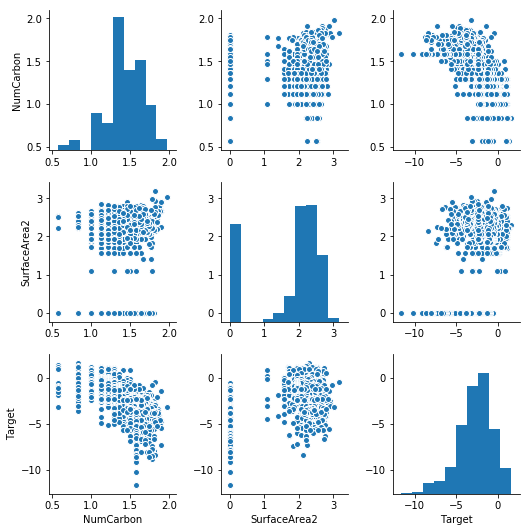

In [96]:
data = X_train[['NumCarbon', 'SurfaceArea2', 'Target']].copy()
data['NumCarbon'] = np.log1p(data['NumCarbon'])
data['SurfaceArea2'] = np.log1p(data['SurfaceArea2'])
sns.pairplot(data)

In [97]:
con_cols = X_train.columns[(X_train.nunique() > 12)]

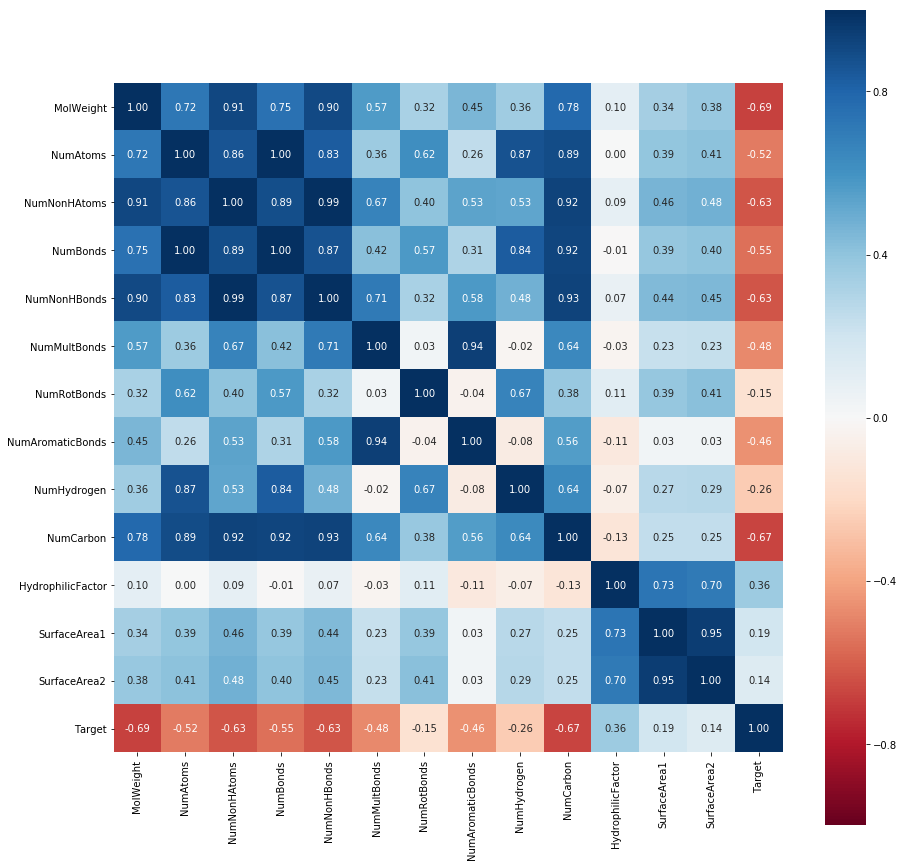

In [98]:
corr = X_train[con_cols].corr(method='spearman')
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, square=True, annot=True, fmt='.2f', vmax=1, vmin=-1, cmap='RdBu', ax=ax)

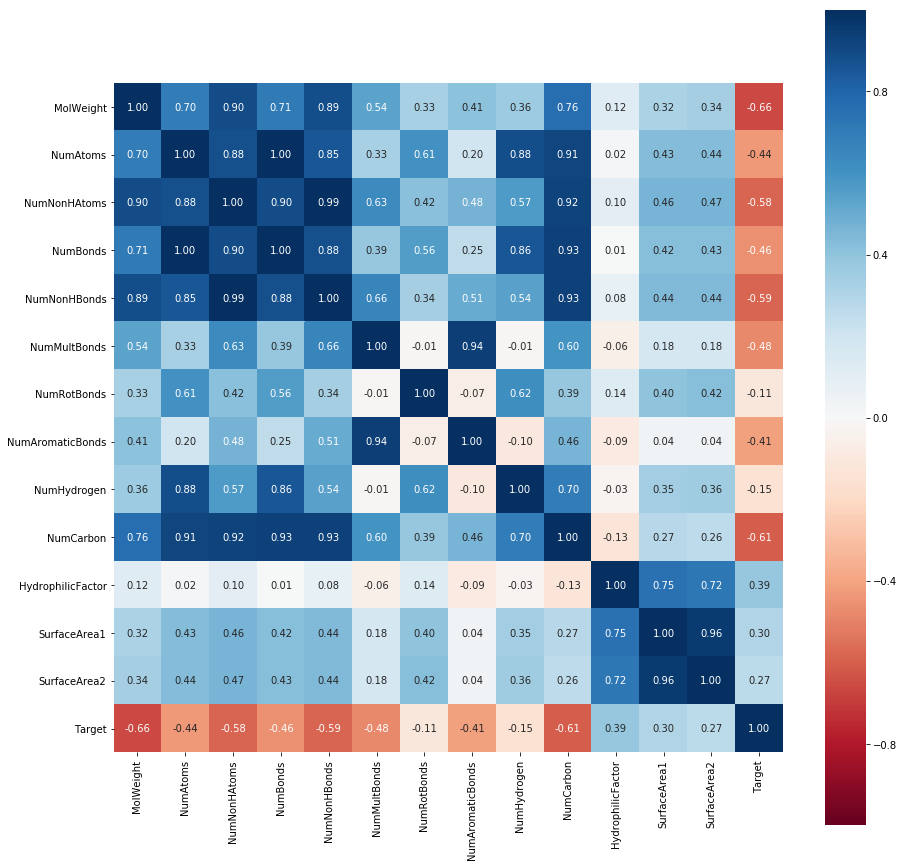

In [99]:
corr = X_train[con_cols].corr(method='pearson')
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, square=True, annot=True, fmt='.2f', vmax=1, vmin=-1, cmap='RdBu', ax=ax)

In [100]:
result = []
for c in bin_cols:
    g = X_train.groupby(c)['Target']
    m0, m1 = g.mean()
    p_val = st.ttest_ind(g.get_group(0), g.get_group(1)).pvalue
    result.append((c, m1-m0, p_val))

In [101]:
result = pd.DataFrame(result, columns=['feature', 'delta_mean', 'p_value'])

Text(0,0.5,'-log(p_value)')

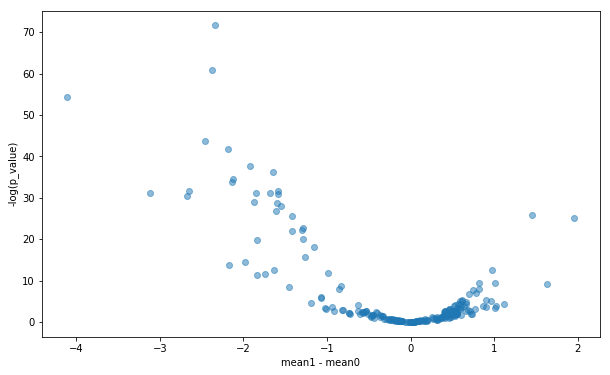

In [102]:
plt.figure(figsize=(10, 6))
plt.plot(result['delta_mean'], -np.log10(result['p_value']), 'o', alpha=.5)
plt.xlabel('mean1 - mean0')
plt.ylabel('-log(p_value)')

In [103]:
result.iloc[np.argmin(result['p_value']), :]

feature             FP076
delta_mean        -2.3428
p_value       2.22329e-72
Name: 75, dtype: object

In [104]:
result.iloc[np.argmax(result['delta_mean'].abs()), :]

feature             FP044
delta_mean       -4.10987
p_value       3.59033e-55
Name: 43, dtype: object

In [114]:
float_cols = X_train.columns[X_train.dtypes==float]

In [127]:
pearson_corr = X_train[float_cols].corr()['Target'][:-1]
spearman_corr = X_train[float_cols].corr(method='spearman')['Target'][:-1]

In [128]:
mic_result = pd.Series(mutual_info_regression(X_train[float_cols[:-1]], y_train.values.ravel()), index=float_cols[:-1])

In [129]:
df = pd.concat([pearson_corr, spearman_corr, mic_result], axis=1)
df.columns = ['correlation', 'rank corr', 'MIC']

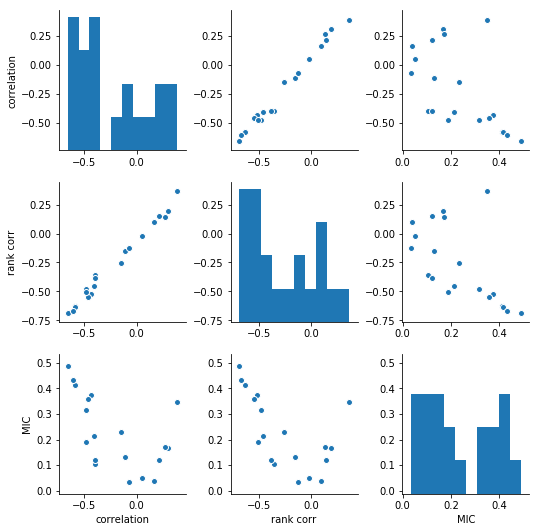

In [130]:
sns.pairplot(df)

In [131]:
mic_result

MolWeight            0.487860
NumAtoms             0.372339
NumNonHAtoms         0.412062
NumBonds             0.358969
NumNonHBonds         0.414318
NumMultBonds         0.316468
NumRotBonds          0.130330
NumDblBonds          0.049965
NumAromaticBonds     0.213114
NumHydrogen          0.231266
NumCarbon            0.430912
NumNitrogen          0.040041
NumOxygen            0.119266
NumSulfer            0.034512
NumChlorine          0.103476
NumHalogen           0.120058
NumRings             0.188831
HydrophilicFactor    0.348273
SurfaceArea1         0.167585
SurfaceArea2         0.170111
dtype: float64

## Categorical Outcomes

In [19]:
data = pd.read_csv('data/segmentationData/segmentationData.csv', index_col=0)

In [20]:
data.shape

(2019, 61)

In [21]:
data.head()

,Cell,Case,Class,AngleCh1,AreaCh1,AvgIntenCh1,AvgIntenCh2,AvgIntenCh3,AvgIntenCh4,ConvexHullAreaRatioCh1,...,TotalIntenCh1,TotalIntenCh2,TotalIntenCh3,TotalIntenCh4,VarIntenCh1,VarIntenCh3,VarIntenCh4,WidthCh1,XCentroid,YCentroid
1,207827637,Test,PS,143.247705,185,15.711864,4.954802,9.548023,2.214689,1.124509,...,2781,701.0,1690,392,12.474676,7.609035,2.714100,10.642974,42,14
2,207932307,Train,PS,133.752037,819,31.923274,206.878517,69.916880,164.153453,1.263158,...,24964,160998.0,54675,128368,18.809225,56.715352,118.388139,32.161261,215,347
3,207932463,Train,WS,106.646387,431,28.038835,116.315534,63.941748,106.696602,1.053310,...,11552,47511.0,26344,43959,17.295643,37.671053,49.470524,21.185525,371,252
4,207932470,Train,PS,69.150325,298,19.456140,102.294737,28.217544,31.028070,1.202625,...,5545,28870.0,8042,8843,13.818968,30.005643,24.749537,13.392830,487,295
5,207932455,Test,PS,2.887837,285,24.275735,112.415441,20.474265,40.577206,1.109333,...,6603,30306.0,5569,11037,15.407972,20.504288,45.450457,13.198561,283,159


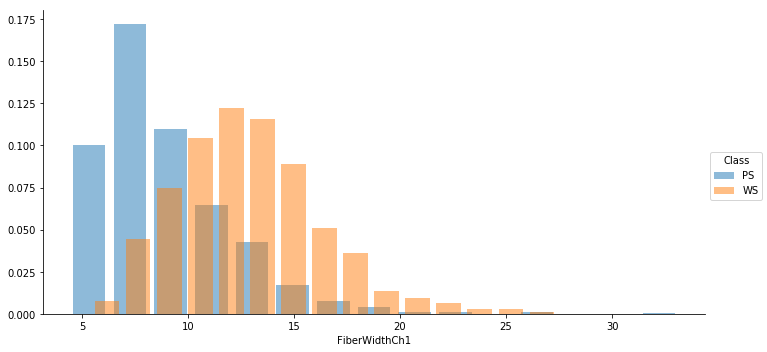

In [22]:
g = sns.FacetGrid(data, hue='Class', size=5, aspect=2)
g.map(plt.hist, 'FiberWidthCh1', alpha=.5, rwidth=.8, bins=15, normed=True).add_legend()

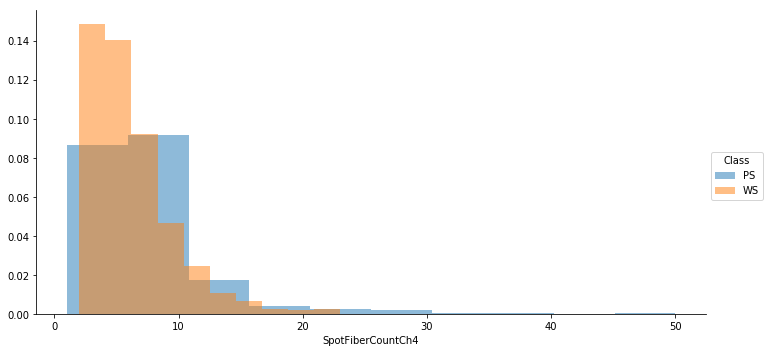

In [23]:
g = sns.FacetGrid(data, hue='Class', size=5, aspect=2)
g.map(plt.hist, 'SpotFiberCountCh4', alpha=.5, normed=True).add_legend()

In [24]:
num_cols = data.columns[data.dtypes==float]

In [25]:
data['Class'], cls_idx = data.Class.factorize()
cls_idx

Index(['PS', 'WS'], dtype='object')

In [26]:
g = data.groupby('Case')


data_test = g.get_group('Test')
data_train = g.get_group('Train')

data_test.shape, data_train.shape

((1010, 61), (1009, 61))

In [58]:
X_train = data_train.iloc[:, 3:]
y_train = data_train['Class']

X_test = data_test.iloc[:, 3:]

y_test = data_test['Class']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1009, 58), (1009,), (1010, 58), (1010,))

In [28]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [29]:
rf_feature_imp = pd.Series(rf.feature_importances_, index=X_train.columns)

In [30]:
ttest_result = {}
for c in X_train.columns:
    g = X_train.groupby(y_train)[c]
    t_stat = st.ttest_ind(*[g.get_group(l) for l in y_train.unique()]).statistic
    ttest_result[c] = abs(t_stat)

In [31]:
ttest_result = pd.Series(ttest_result)

In [32]:
clf = LogisticRegression()

In [33]:
roc_result = {}
for c in X_train.columns:
    clf.fit(X_train[[c]], y_train)
    y_pred = clf.predict_proba(X_train[[c]])[:, 1]
    roc_result[c] = roc_auc_score(y_train, y_pred)

In [34]:
roc_result = pd.Series(roc_result)

In [60]:
mic_result = pd.Series(mutual_info_classif(X_train, y_train), index=X_train.columns)

In [61]:
mic_result

AngleCh1                   0.015024
AreaCh1                    0.001228
AvgIntenCh1                0.113377
AvgIntenCh2                0.147516
AvgIntenCh3                0.017978
AvgIntenCh4                0.033586
ConvexHullAreaRatioCh1     0.127272
ConvexHullPerimRatioCh1    0.100356
DiffIntenDensityCh1        0.098199
DiffIntenDensityCh3        0.012717
DiffIntenDensityCh4        0.017604
EntropyIntenCh1            0.090454
EntropyIntenCh3            0.040578
EntropyIntenCh4            0.053455
EqCircDiamCh1              0.000000
EqEllipseLWRCh1            0.073933
EqEllipseOblateVolCh1      0.000000
EqEllipseProlateVolCh1     0.011890
EqSphereAreaCh1            0.000000
EqSphereVolCh1             0.000067
FiberAlign2Ch3             0.032617
FiberAlign2Ch4             0.025709
FiberLengthCh1             0.070707
FiberWidthCh1              0.178390
IntenCoocASMCh3            0.069875
IntenCoocASMCh4            0.010646
IntenCoocContrastCh3       0.073750
IntenCoocContrastCh4       0

In [62]:
df = pd.concat([ttest_result, rf_feature_imp, roc_result, mic_result], axis=1)
df.columns = ['ttest', 'rf', 'auc', 'MIC']

In [63]:
df['ch'] = df.index.str[-3:]

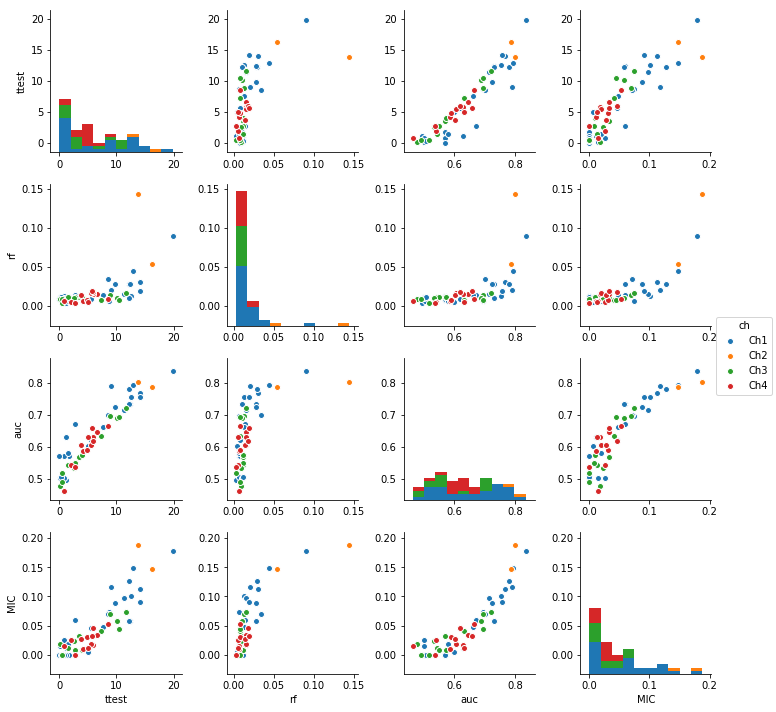

In [64]:
sns.pairplot(df.iloc[:-2, :], hue='ch')